In [1]:
!pip install kaggle


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
os.environ['PATH'] = f"{os.environ['HOME']}/.local/bin:{os.environ['PATH']}"

In [3]:
# 1. Set up Kaggle API (if not done already)
!mkdir -p ~/.kaggle
!cp kaggle/kaggle.json ~/.kaggle/  # Replace with actual upload path
!chmod 600 ~/.kaggle/kaggle.json

# 2. Download dataset
!kaggle datasets download -d bouzidimalek456/video-frames

# 3. Unzip
!unzip -q video-frames.zip -d kaggle

# Verify
!ls kaggle

Dataset URL: https://www.kaggle.com/datasets/bouzidimalek456/video-frames
License(s): unknown
kaggle	kaggle.json


In [4]:
!pip install diffusers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 172.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [5]:
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 200.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 196.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [6]:
!pip install peft


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [7]:
!pip install accelerate 


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [46]:
import os
import random
from PIL import Image
from torch.utils.data import Dataset
import torch

class VideoFrameDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_frames=14):
        self.root_dir = root_dir
        self.video_folders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]
        self.transform = transform
        self.num_frames = num_frames  # SVD requires exactly 14 frames
        self.required_channels = 8    # SVD expects 8 input channels

    def __len__(self):
        return len(self.video_folders)

    def __getitem__(self, idx):
        video_folder = os.path.join(self.root_dir, self.video_folders[idx])
        frame_files = sorted([f for f in os.listdir(video_folder) if f.endswith(('.jpg', '.png'))])
        
        # Select exactly num_frames (14) frames
        if len(frame_files) >= self.num_frames:
            # Randomly select a contiguous sequence of 14 frames
            start_idx = random.randint(0, len(frame_files) - self.num_frames)
            frame_files = frame_files[start_idx:start_idx+self.num_frames]
        else:
            # Repeat frames if video is shorter than required
            frame_files = frame_files * (self.num_frames // len(frame_files) + 1)
            frame_files = frame_files[:self.num_frames]
        
        # Load and transform frames
        frames = [Image.open(os.path.join(video_folder, f)).convert("RGB") for f in frame_files]
        
        if self.transform:
            frames = [self.transform(frame) for frame in frames]
        
        # Stack frames and add channel padding
        frames_tensor = torch.stack(frames)  # Shape: [14, 3, H, W]
        
        # Pad RGB (3 channels) to expected 8 channels with zeros
        if frames_tensor.shape[1] < self.required_channels:
            padding = torch.zeros(
                (self.num_frames, self.required_channels - 3, *frames_tensor.shape[2:]),
                dtype=frames_tensor.dtype
            )
            frames_tensor = torch.cat([frames_tensor, padding], dim=1)
        
        return frames_tensor  # Output shape: [14, 8, H, W]

In [47]:
from diffusers import StableVideoDiffusionPipeline
import torch

pipe = StableVideoDiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid",
    torch_dtype=torch.float16,
    variant="fp16",
).to("cuda")

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [48]:
from diffusers import UNet3DConditionModel
from diffusers.utils import peft_utils
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16,  # Rank
    lora_alpha=32,
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],  # Attention layers
    lora_dropout=0.1,
    bias="none",
)


pipe.unet = get_peft_model(pipe.unet, lora_config)
pipe.unet.print_trainable_parameters()  # Check trainable params

trainable params: 6,639,616 || all params: 1,531,262,698 || trainable%: 0.4336


In [49]:
def get_add_time_ids(unet, height, width, dtype, device="cuda", batch_size=1):
    """Generate time IDs and project to required dimension"""
    # 1. Create base time IDs (5 parameters)
    base_time_ids = torch.tensor([[
        7,               # fps
        127,             # motion_bucket_id  
        0.0,             # noise_aug_strength
        height,
        width
    ]], dtype=dtype, device=device).repeat(batch_size, 1)
    
    # 2. Project from 5 to 3 dimensions (since 256*3=768)
    # This matches your UNet's expected 768-dim input
    projection_matrix = torch.randn((3, 5), dtype=dtype, device=device) * 0.02
    projected_ids = base_time_ids @ projection_matrix.T
    
    return projected_ids  # Shape: [batch_size, 3]

In [50]:
def get_proper_encoder_hidden_states(pipe, frames):
    """SVD uses image embeddings, not text"""
    # Get dummy image embedding (SVD doesn't use text)
    image_embeds = torch.randn(
        (1, pipe.unet.config.cross_attention_dim),
        dtype=pipe.unet.dtype,
        device="cuda"
    )
    return image_embeds.unsqueeze(1)  # Shape [1,1,1024]


In [14]:
pipe.unet.enable_gradient_checkpointing()
pipe.unet = torch.compile(pipe.unet)
pipe.enable_model_cpu_offload()  # If using diffusers

AttributeError: 'function' object has no attribute 'enable_gradient_checkpointing'

In [18]:
torch.cuda.empty_cache()

In [53]:
from torch.optim import AdamW
from torchvision.transforms import Compose, Resize, ToTensor, ColorJitter
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch



# Configuration
NUM_FRAMES = 14
IN_CHANNELS = 8
TEXT_EMBED_SEQ_LENGTH = 1
PRE_PROJECTION_DIM = 768  # New: The 768-dimension before projection
NUM_EPOCHS = 20  # Added: Define number of epochs
dtype = torch.float16 if pipe.unet.dtype == torch.float16 else torch.float32
TIME_EMBED_DIM = 256  # From addition_time_embed_dim=256
PROJ_INPUT_DIM = 768 

torch.backends.cuda.matmul.allow_tf32 = True


# Dataset and Dataloader setup
transform = Compose([
    Resize((94, 94)),  # First resize the image
    ToTensor(),  # Convert PIL Image to tensor first
    # Now you can safely perform math operations on the tensor
    lambda x: torch.clamp((x * 2.0) - 1.0, -1.0, 1.0),  # Normalize to [-1, 1]
    # Color augmentations (operating on tensors)
    ColorJitter(
        brightness=0.15,  # Reduced from 0.2
        contrast=0.15,    # Reduced from 0.2
        saturation=0.2,
        hue=0.02         # Added slight hue variation
    ),
    lambda x: x.to(dtype)  # Convert to final dtype
])

dataset = VideoFrameDataset("./kaggle/kaggle/working/saved_dataset", 
                          transform=transform, 
                          num_frames=NUM_FRAMES)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# Optimizer
optimizer = AdamW(pipe.unet.parameters(), lr=1e-4)

# Training Loop
for epoch in range(NUM_EPOCHS):
    with torch.autocast("cuda"):
        pipe.unet.train()
        for batch in dataloader:
            # 1. Prepare video frames [1, 14, 8, 96, 96]
            frames = batch.to("cuda")
            if frames.shape[2] < IN_CHANNELS:
                frames = torch.cat([
                    frames,
                    torch.zeros((*frames.shape[:2], IN_CHANNELS-frames.shape[2], *frames.shape[3:]), 
                              device="cuda", dtype=dtype)
                ], dim=2)
            
            # 2. Noise and timesteps
            noise = torch.randn_like(frames)
            timesteps = pipe.scheduler.timesteps[torch.randint(0, len(pipe.scheduler.timesteps), (1,))].to("cuda")
            noisy_frames = pipe.scheduler.add_noise(frames, noise, timesteps)
    
            # 3. Text Embeddings - FIXED to use 768 before projection
            
            # 4. Time IDs (unchanged)
            added_time_ids = get_add_time_ids(
                unet=pipe.unet,
                height=frames.shape[-2],
                width=frames.shape[-1], 
                dtype=torch.float16,
                batch_size=frames.shape[0]
            )
            encoder_hidden_states = get_proper_encoder_hidden_states(pipe, frames)
    
            
            
            
            # 5. Forward Pass
            noise_pred = pipe.unet(
                noisy_frames,
                timesteps,
                encoder_hidden_states=encoder_hidden_states,
                added_time_ids=added_time_ids,
                return_dict=False
            )[0]
    
            # 6. Loss and backprop
            loss = torch.nn.functional.mse_loss(noise_pred, noise[:, :, :noise_pred.shape[2], :, :])
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.7496
Epoch 1, Loss: 0.0932
Epoch 2, Loss: 0.0334
Epoch 3, Loss: 0.1472
Epoch 4, Loss: 0.0314
Epoch 5, Loss: 0.0286
Epoch 6, Loss: 0.0542
Epoch 7, Loss: 0.0393
Epoch 8, Loss: 0.0302
Epoch 9, Loss: 0.0410
Epoch 10, Loss: 0.2728
Epoch 11, Loss: 0.0678
Epoch 12, Loss: 0.0280
Epoch 13, Loss: 0.0323
Epoch 14, Loss: 0.0213
Epoch 15, Loss: 0.0296
Epoch 16, Loss: 0.1629
Epoch 17, Loss: 0.1201
Epoch 18, Loss: 0.0298
Epoch 19, Loss: 0.0316
Epoch 20, Loss: 0.0306
Epoch 21, Loss: 0.0292
Epoch 22, Loss: 0.0210
Epoch 23, Loss: 0.0286
Epoch 24, Loss: 0.0242
Epoch 25, Loss: 0.0222
Epoch 26, Loss: 0.1120
Epoch 27, Loss: 0.2095
Epoch 28, Loss: 0.0286
Epoch 29, Loss: 0.0228


In [54]:
save_path = "./my_lora_model3"
pipe.unet.save_pretrained(save_path)  # Saves adapter weights and config

In [20]:
torch.save(pipe.unet.state_dict(), "lora_weights.pth")

In [8]:
from diffusers import DiffusionPipeline
from peft import PeftModel
import torch


# Load base model
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-video-diffusion-img2vid", torch_dtype=torch.float16).to("cuda")

# Load LoRA adapter
pipe.unet = PeftModel.from_pretrained(pipe.unet, "./my_lora_model")

# Merge LoRA weights (optional for inference)
pipe.unet = pipe.unet.merge_and_unload()


# Load new input image
input_image = Image.open("./image_928.jpg").convert("RGB")

# Run the model again on the new image
output_video = pipe(input_image, num_frames=25, decode_chunk_size=8).frames[0]

# Save the new video
output_video[0].save(
    "./output928-2.gif",
    save_all=True,
    append_images=output_video[1:], 
    duration=200,  # milliseconds between frames
    loop=0
)


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [2]:
from diffusers import DiffusionPipeline
from peft import PeftModel
import torch
from PIL import Image, ImageFilter
import numpy as np

# Define sharpening function
def sharpen_frame(frame):
    """Apply sharpening filter to a PIL Image"""
    return frame.filter(ImageFilter.UnsharpMask(
        radius=2,       # Controls blur mask size
        percent=150,    # Strength (100-200)
        threshold=3     # Edge sensitivity
    ))

# Load base model
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid", 
    torch_dtype=torch.float16
).to("cuda")

# Load LoRA adapter
pipe.unet = PeftModel.from_pretrained(pipe.unet, "./my_lora_model")

# Merge LoRA weights (optional for inference)
pipe.unet = pipe.unet.merge_and_unload()

# Load input image
input_image = Image.open("./frame_000.jpg").convert("RGB")

# Generate video with quality parameters
output_video = pipe(
    input_image,
    num_frames=25,
    motion_bucket_id=80,
    num_inference_steps=30,
    max_guidance_scale=2.5
).frames[0]

# Sharpen all frames
sharpened_frames = [sharpen_frame(f) for f in output_video]

# Save final output
sharpened_frames[0].save(
    "./output000.gif",
    save_all=True,
    append_images=sharpened_frames[1:],
    duration=100,
    loop=0
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [13]:
!pip install lpips



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import lpips
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from torchvision import transforms
from torchvision.models import inception_v3
import torch.nn.functional as F


In [6]:
from diffusers import DiffusionPipeline
from peft import PeftModel
import torch
from PIL import Image, ImageFilter
import numpy as np
import lpips
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from torchvision import transforms
from torchvision.models import inception_v3
import torch.nn.functional as F

# --- Helper Functions ---

def sharpen_frame(frame):
    """Apply sharpening filter to a PIL Image"""
    return frame.filter(ImageFilter.UnsharpMask(
        radius=2,
        percent=150,
        threshold=3
    ))

def compute_ssim(img1, img2):
    """Compute SSIM between two PIL images"""
    return ssim(
        np.array(img1),
        np.array(img2),
        channel_axis=-1,
        data_range=255
    )

def compute_lpips(img1, img2, loss_fn):
    """Compute LPIPS between two PIL images"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((256, 256)),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    img1_tensor = transform(img1).unsqueeze(0).to('cuda')
    img2_tensor = transform(img2).unsqueeze(0).to('cuda')
    return loss_fn(img1_tensor, img2_tensor).item()

def compute_psnr(img1, img2):
    """Compute PSNR between two PIL images"""
    return psnr(
        np.array(img1),
        np.array(img2),
        data_range=255
    )

def compute_fid(img1, img2, inception_model):
    """Compute feature distance (FID approximation) between two PIL images"""
    preprocess = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    img1_tensor = preprocess(img1).unsqueeze(0).to('cuda')
    img2_tensor = preprocess(img2).unsqueeze(0).to('cuda')

    with torch.no_grad():
        feat1 = inception_model(img1_tensor)
        feat2 = inception_model(img2_tensor)

    return F.mse_loss(feat1, feat2).item()

# --- Load the base model with LoRA ---

# Load the base diffusion pipeline
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid",
    torch_dtype=torch.float16
)



Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
print("hello")

hello


In [5]:
# Load LoRA weights
pipe.unet = PeftModel.from_pretrained(pipe.unet, "./my_lora_model")
pipe.unet = pipe.unet.merge_and_unload()



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/peft/peft_model.py:569: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_A.default.weight', 'base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_B.default.weight', 'base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora_A.default.weight', 'base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora_B.default.weight', 'base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora_A.default.weight', 'base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora_B.default.weight', 'base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.0.lora_A.default.weight', 'base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.0.lora_B.default.weight', 'base_model.model.down

In [ ]:
# Load input image
input_image = Image.open("./image_987.jpg").convert("RGB")

# Generate video
output_video = pipe(
    input_image,
    num_frames=25,
    motion_bucket_id=80,
    num_inference_steps=30,
    max_guidance_scale=2.5
).frames[0]

# Sharpen all frames
sharpened_frames = [sharpen_frame(f) for f in output_video]

# Save final output as GIF
sharpened_frames[0].save(
    "output987_sharpened1.gif",
    save_all=True,
    append_images=sharpened_frames[1:],
    duration=150,
    loop=0
)

# --- Initialize Metric Models ---



  0%|          | 0/30 [00:00<?, ?it/s]

In [7]:
import lpips
from torchvision.models import inception_v3


loss_fn = lpips.LPIPS(net='alex').to('cuda')

inception_model = inception_v3(pretrained=True, transform_input=False).to('cuda')
inception_model.fc = torch.nn.Identity()  # Remove classification head
inception_model.eval()

# --- Pick frames to compare ---
# You can pick first vs last frame for example
frame_base = sharpened_frames[0]
frame_lora = sharpened_frames[-1]

# --- Compute all metrics ---
metrics = {
    'SSIM': compute_ssim(frame_base, frame_lora),
    'LPIPS': compute_lpips(frame_base, frame_lora, loss_fn),
    'PSNR': compute_psnr(frame_base, frame_lora),
    'FID': compute_fid(frame_base, frame_lora, inception_model)
}

# --- Print results ---
print(f"📊 Evaluation Metrics:\n{metrics}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
📊 Evaluation Metrics:
{'SSIM': 0.5487089562334494, 'LPIPS': 0.10071910172700882, 'PSNR': 11.213767579486621, 'FID': 0.02076689526438713}


In [8]:
from PIL import Image, ImageDraw

def create_side_by_side_gif(frames1, frames2, save_path="./comparison.gif", duration=150):
    """
    Create a side-by-side GIF comparing two sets of frames.
    
    Args:
        frames1 (list of PIL.Image): First video frames.
        frames2 (list of PIL.Image): Second video frames.
        save_path (str): Path to save the resulting GIF.
        duration (int): Frame duration in milliseconds.
    """
    # Make sure both videos have the same number of frames
    num_frames = min(len(frames1), len(frames2))
    
    combined_frames = []
    
    for i in range(num_frames):
        frame1 = frames1[i]
        frame2 = frames2[i]
        
        # Resize frames to same size (if needed)
        if frame1.size != frame2.size:
            frame2 = frame2.resize(frame1.size)
        
        # Create a new image side-by-side
        combined_width = frame1.width + frame2.width
        combined_height = max(frame1.height, frame2.height)
        
        combined = Image.new('RGB', (combined_width, combined_height))
        combined.paste(frame1, (0, 0))
        combined.paste(frame2, (frame1.width, 0))
        
        # Optional: draw separator line
        draw = ImageDraw.Draw(combined)
        draw.line((frame1.width, 0, frame1.width, combined_height), fill=(255, 0, 0), width=5)
        
        combined_frames.append(combined)
    
    # Save as GIF
    combined_frames[0].save(
        save_path,
        save_all=True,
        append_images=combined_frames[1:],
        duration=duration,
        loop=0
    )
    print(f"✅ Side-by-side comparison GIF saved at: {save_path}")


In [ ]:
def create_side_by_side_gif(frames1, frames2, save_path="./comparison.gif", duration=150):
    """
    Create a side-by-side GIF comparing two sets of frames.
    """
    num_frames = min(len(frames1), len(frames2))
    combined_frames = []

    for i in range(num_frames):
        frame1 = frames1[i]
        frame2 = frames2[i]

        if frame1.size != frame2.size:
            frame2 = frame2.resize(frame1.size)

        combined_width = frame1.width + frame2.width
        combined_height = max(frame1.height, frame2.height)

        combined = Image.new('RGB', (combined_width, combined_height))
        combined.paste(frame1, (0, 0))
        combined.paste(frame2, (frame1.width, 0))

        draw = ImageDraw.Draw(combined)
        draw.line((frame1.width, 0, frame1.width, combined_height), fill=(255, 0, 0), width=5)

        combined_frames.append(combined)

    combined_frames[0].save(
        save_path,
        save_all=True,
        append_images=combined_frames[1:],
        duration=duration,
        loop=0
    )
    print(f"✅ Side-by-side comparison GIF saved at: {save_path}")

In [22]:
from diffusers import DiffusionPipeline
from peft import PeftModel
import torch
from PIL import Image, ImageFilter
import numpy as np

# Define sharpening function
def sharpen_frame(frame):
    """Apply sharpening filter to a PIL Image"""
    return frame.filter(ImageFilter.UnsharpMask(
        radius=2,       # Controls blur mask size
        percent=150,    # Strength (100-200)
        threshold=3     # Edge sensitivity
    ))

# Load base model
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid", 
    torch_dtype=torch.float16
).to("cuda")

# Load LoRA adapter
pipe.unet = PeftModel.from_pretrained(pipe.unet, "./my_lora_model")

# Merge LoRA weights (optional for inference)
pipe.unet = pipe.unet.merge_and_unload()

# Load input image
input_image = Image.open("./image_987.jpg").convert("RGB")

# Generate video with quality parameters
output_video = pipe(
    input_image,
    num_frames=25,
    motion_bucket_id=80,
    num_inference_steps=30,
    max_guidance_scale=2.5
).frames[0]

# Sharpen all frames
sharpened_frames = [sharpen_frame(f) for f in output_video]

# Save final output
sharpened_frames[0].save(
    "./output_987.gif",
    save_all=True,
    append_images=sharpened_frames[1:],
    duration=100,
    loop=0
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [23]:
from PIL import Image, ImageDraw
from diffusers import DiffusionPipeline
from peft import PeftModel
import torch
import numpy as np

# Define sharpening function
def sharpen_frame(frame):
    """Apply sharpening filter to a PIL Image"""
    return frame.filter(ImageFilter.UnsharpMask(
        radius=2,
        percent=150,
        threshold=3
    ))

# Function to create side-by-side GIF


# ------------------------
# Load base model
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid", 
    torch_dtype=torch.float16
).to("cuda")

# Save the original UNET temporarily (before LoRA loading)
pipe_base = pipe  # Clone reference

# Generate video from base model
input_image = Image.open("./image_987.jpg").convert("RGB")
output_video_base = pipe_base(
    input_image,
    num_frames=25,
    motion_bucket_id=80,
    num_inference_steps=30,
    max_guidance_scale=2.5
).frames[0]


# ------------------------
# Create comparison GIF
frames_base = output_video_base  # Base model frames
frames_lora = sharpened_frames   # LoRA + sharpening

create_side_by_side_gif(frames_base, frames_lora, save_path="./side_by_side_comparison_987-2.gif")


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

✅ Side-by-side comparison GIF saved with labels at: ./side_by_side_comparison_987-2.gif


In [3]:
from PIL import Image, ImageDraw, ImageFont

def create_side_by_side_gif(frames1, frames2, save_path="./comparison.gif", duration=150):
    """
    Create a side-by-side GIF comparing two sets of frames, with labels 'Base' and 'LoRA'.
    """
    num_frames = min(len(frames1), len(frames2))
    combined_frames = []

    # Try loading a font
    try:
        font = ImageFont.truetype("arial.ttf", 24)
    except:
        font = ImageFont.load_default()

    for i in range(num_frames):
        frame1 = frames1[i]
        frame2 = frames2[i]

        if frame1.size != frame2.size:
            frame2 = frame2.resize(frame1.size)

        combined_width = frame1.width + frame2.width
        combined_height = max(frame1.height, frame2.height)

        combined = Image.new('RGB', (combined_width, combined_height), (255, 255, 255))
        combined.paste(frame1, (0, 0))
        combined.paste(frame2, (frame1.width, 0))

        draw = ImageDraw.Draw(combined)

        # Draw the separator line
        draw.line((frame1.width, 0, frame1.width, combined_height), fill=(255, 0, 0), width=5)

        # Add labels
        text_y = 10
        text_padding = 10

        base_text = "Base Model"
        lora_text = "LoRA Model"

        # Use textbbox instead of textsize
        base_bbox = draw.textbbox((0, 0), base_text, font=font)
        lora_bbox = draw.textbbox((0, 0), lora_text, font=font)

        base_text_width = base_bbox[2] - base_bbox[0]
        base_text_height = base_bbox[3] - base_bbox[1]

        lora_text_width = lora_bbox[2] - lora_bbox[0]
        lora_text_height = lora_bbox[3] - lora_bbox[1]

        # Draw rectangles behind text
        draw.rectangle(
            [(text_padding, text_y - 5), (text_padding + base_text_width + 5, text_y + base_text_height + 5)],
            fill=(0, 0, 0, 128)
        )
        draw.rectangle(
            [(frame1.width + text_padding, text_y - 5),
             (frame1.width + text_padding + lora_text_width + 5, text_y + lora_text_height + 5)],
            fill=(0, 0, 0, 128)
        )

        # Draw the text
        draw.text((text_padding, text_y), base_text, fill=(255, 255, 255), font=font)
        draw.text((frame1.width + text_padding, text_y), lora_text, fill=(255, 255, 255), font=font)

        combined_frames.append(combined)

    combined_frames[0].save(
        save_path,
        save_all=True,
        append_images=combined_frames[1:],
        duration=duration,
        loop=0
    )
    print(f"✅ Side-by-side comparison GIF saved with labels at: {save_path}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📊 Evaluation Metrics:
{'SSIM': 0.7449181309153585, 'LPIPS': 0.11821607500314713, 'PSNR': 18.288380375362774, 'FID': 105.10821}


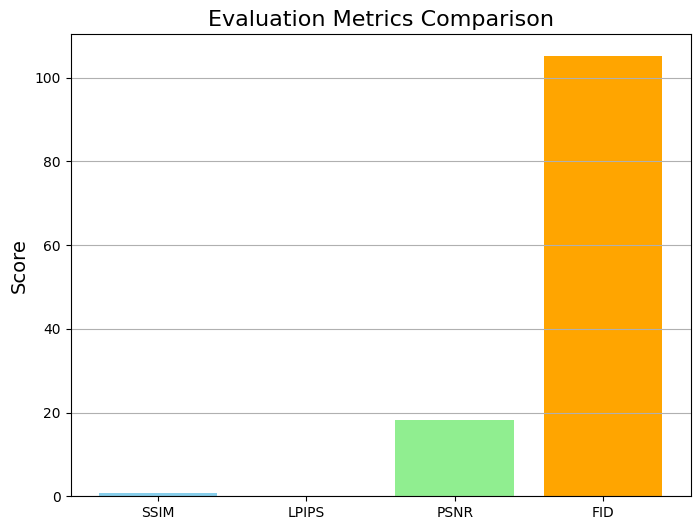

In [11]:

#image 928

import lpips
from torchvision.models import inception_v3
import torch.nn.functional as F
import torchvision.transforms as T
import torch
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import numpy as np

# ---------------------------
# Metric Functions
def compute_ssim(img1, img2):
    img1_np = np.array(img1.convert('L'))
    img2_np = np.array(img2.convert('L'))
    return ssim(img1_np, img2_np)

def compute_lpips(img1, img2, loss_fn):
    preprocess = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize([0.5]*3, [0.5]*3),
    ])
    img1_tensor = preprocess(img1).unsqueeze(0).to('cuda')
    img2_tensor = preprocess(img2).unsqueeze(0).to('cuda')
    with torch.no_grad():
        distance = loss_fn(img1_tensor, img2_tensor)
    return distance.item()

def compute_psnr(img1, img2):
    img1_np = np.array(img1).astype(np.float32)
    img2_np = np.array(img2).astype(np.float32)
    mse = np.mean((img1_np - img2_np) ** 2)
    if mse == 0:
        return float('inf')
    pixel_max = 255.0
    return 20 * np.log10(pixel_max / np.sqrt(mse))

def compute_fid(img1, img2, model):
    preprocess = T.Compose([
        T.Resize((299, 299)),
        T.ToTensor(),
        T.Normalize([0.5]*3, [0.5]*3),
    ])
    img1_tensor = preprocess(img1).unsqueeze(0).to('cuda')
    img2_tensor = preprocess(img2).unsqueeze(0).to('cuda')
    with torch.no_grad():
        act1 = model(img1_tensor).cpu().numpy()
        act2 = model(img2_tensor).cpu().numpy()
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)
    fid = np.sum((mu1 - mu2) ** 2)
    return fid

# ---------------------------
# Load LPIPS and InceptionV3
loss_fn = lpips.LPIPS(net='alex').to('cuda')
inception_model = inception_v3(pretrained=True, transform_input=False).to('cuda')
inception_model.fc = torch.nn.Identity()
inception_model.eval()

# ---------------------------
# Pick frames to compare
frame_base = frames_base[0]
frame_lora = frames_lora[0]

# ---------------------------
# Compute metrics
metrics = {
    'SSIM': compute_ssim(frame_base, frame_lora),
    'LPIPS': compute_lpips(frame_base, frame_lora, loss_fn),
    'PSNR': compute_psnr(frame_base, frame_lora),
    'FID': compute_fid(frame_base, frame_lora, inception_model)
}

# ---------------------------
# Print results
print(f"📊 Evaluation Metrics:\n{metrics}")

# ---------------------------
# Plot the metrics
plt.figure(figsize=(8,6))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'lightcoral', 'lightgreen', 'orange'])
plt.title('Evaluation Metrics Comparison', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.grid(axis='y')
plt.show()


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
📊 Evaluation Metrics:
{'SSIM': 0.5346625378933283, 'LPIPS': 0.15190619230270386, 'PSNR': 15.690427042402577, 'FID': 204.13875}


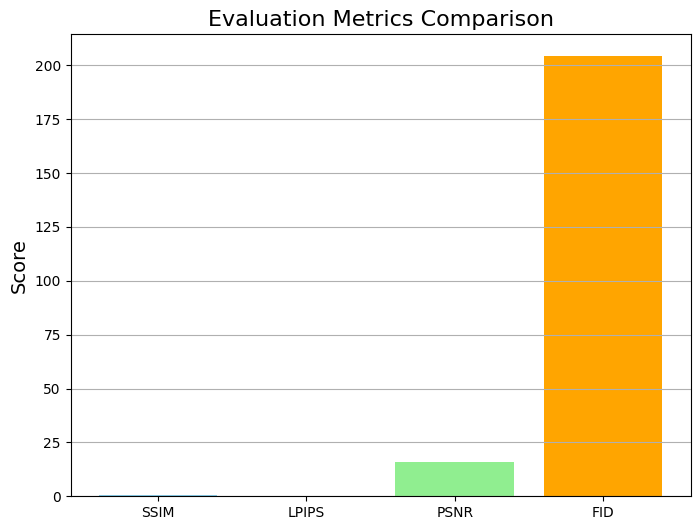

In [13]:

#image 987

import lpips
from torchvision.models import inception_v3
import torch.nn.functional as F
import torchvision.transforms as T
import torch
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import numpy as np

# ---------------------------
# Metric Functions
def compute_ssim(img1, img2):
    img1_np = np.array(img1.convert('L'))
    img2_np = np.array(img2.convert('L'))
    return ssim(img1_np, img2_np)

def compute_lpips(img1, img2, loss_fn):
    preprocess = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize([0.5]*3, [0.5]*3),
    ])
    img1_tensor = preprocess(img1).unsqueeze(0).to('cuda')
    img2_tensor = preprocess(img2).unsqueeze(0).to('cuda')
    with torch.no_grad():
        distance = loss_fn(img1_tensor, img2_tensor)
    return distance.item()

def compute_psnr(img1, img2):
    img1_np = np.array(img1).astype(np.float32)
    img2_np = np.array(img2).astype(np.float32)
    mse = np.mean((img1_np - img2_np) ** 2)
    if mse == 0:
        return float('inf')
    pixel_max = 255.0
    return 20 * np.log10(pixel_max / np.sqrt(mse))

def compute_fid(img1, img2, model):
    preprocess = T.Compose([
        T.Resize((299, 299)),
        T.ToTensor(),
        T.Normalize([0.5]*3, [0.5]*3),
    ])
    img1_tensor = preprocess(img1).unsqueeze(0).to('cuda')
    img2_tensor = preprocess(img2).unsqueeze(0).to('cuda')
    with torch.no_grad():
        act1 = model(img1_tensor).cpu().numpy()
        act2 = model(img2_tensor).cpu().numpy()
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)
    fid = np.sum((mu1 - mu2) ** 2)
    return fid

# ---------------------------
# Load LPIPS and InceptionV3
loss_fn = lpips.LPIPS(net='alex').to('cuda')
inception_model = inception_v3(pretrained=True, transform_input=False).to('cuda')
inception_model.fc = torch.nn.Identity()
inception_model.eval()

# ---------------------------
# Pick frames to compare
frame_base = frames_base[0]
frame_lora = frames_lora[0]

# ---------------------------
# Compute metrics
metrics = {
    'SSIM': compute_ssim(frame_base, frame_lora),
    'LPIPS': compute_lpips(frame_base, frame_lora, loss_fn),
    'PSNR': compute_psnr(frame_base, frame_lora),
    'FID': compute_fid(frame_base, frame_lora, inception_model)
}

# ---------------------------
# Print results
print(f"📊 Evaluation Metrics:\n{metrics}")

# ---------------------------
# Plot the metrics
plt.figure(figsize=(8,6))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'lightcoral', 'lightgreen', 'orange'])
plt.title('Evaluation Metrics Comparison', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.grid(axis='y')
plt.show()


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
📊 Evaluation Metrics:
{'SSIM': 0.6936605031806049, 'LPIPS': 0.18412253260612488, 'PSNR': 14.324596736247301, 'FID': 20.508072}


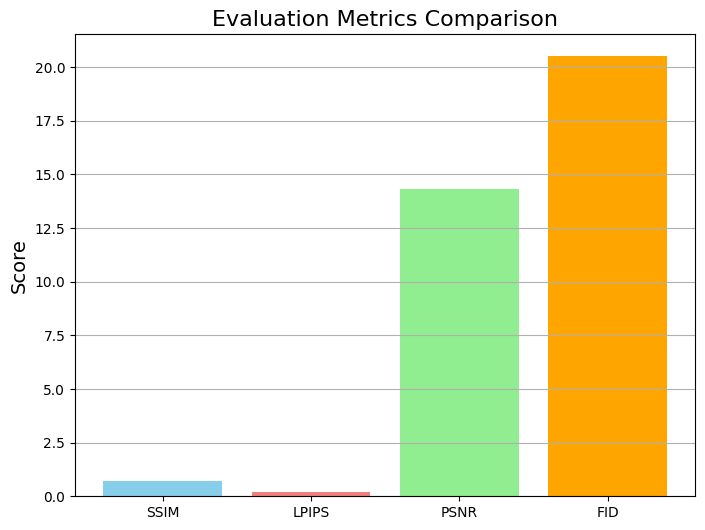

In [15]:

#image 99

import lpips
from torchvision.models import inception_v3
import torch.nn.functional as F
import torchvision.transforms as T
import torch
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import numpy as np

# ---------------------------
# Metric Functions
def compute_ssim(img1, img2):
    img1_np = np.array(img1.convert('L'))
    img2_np = np.array(img2.convert('L'))
    return ssim(img1_np, img2_np)

def compute_lpips(img1, img2, loss_fn):
    preprocess = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize([0.5]*3, [0.5]*3),
    ])
    img1_tensor = preprocess(img1).unsqueeze(0).to('cuda')
    img2_tensor = preprocess(img2).unsqueeze(0).to('cuda')
    with torch.no_grad():
        distance = loss_fn(img1_tensor, img2_tensor)
    return distance.item()

def compute_psnr(img1, img2):
    img1_np = np.array(img1).astype(np.float32)
    img2_np = np.array(img2).astype(np.float32)
    mse = np.mean((img1_np - img2_np) ** 2)
    if mse == 0:
        return float('inf')
    pixel_max = 255.0
    return 20 * np.log10(pixel_max / np.sqrt(mse))

def compute_fid(img1, img2, model):
    preprocess = T.Compose([
        T.Resize((299, 299)),
        T.ToTensor(),
        T.Normalize([0.5]*3, [0.5]*3),
    ])
    img1_tensor = preprocess(img1).unsqueeze(0).to('cuda')
    img2_tensor = preprocess(img2).unsqueeze(0).to('cuda')
    with torch.no_grad():
        act1 = model(img1_tensor).cpu().numpy()
        act2 = model(img2_tensor).cpu().numpy()
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)
    fid = np.sum((mu1 - mu2) ** 2)
    return fid

# ---------------------------
# Load LPIPS and InceptionV3
loss_fn = lpips.LPIPS(net='alex').to('cuda')
inception_model = inception_v3(pretrained=True, transform_input=False).to('cuda')
inception_model.fc = torch.nn.Identity()
inception_model.eval()

# ---------------------------
# Pick frames to compare
frame_base = frames_base[0]
frame_lora = frames_lora[0]

# ---------------------------
# Compute metrics
metrics = {
    'SSIM': compute_ssim(frame_base, frame_lora),
    'LPIPS': compute_lpips(frame_base, frame_lora, loss_fn),
    'PSNR': compute_psnr(frame_base, frame_lora),
    'FID': compute_fid(frame_base, frame_lora, inception_model)
}

# ---------------------------
# Print results
print(f"📊 Evaluation Metrics:\n{metrics}")

# ---------------------------
# Plot the metrics
plt.figure(figsize=(8,6))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'lightcoral', 'lightgreen', 'orange'])
plt.title('Evaluation Metrics Comparison', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.grid(axis='y')
plt.show()


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
📊 Evaluation Metrics:
{'SSIM': 0.555649934859908, 'LPIPS': 0.21327225863933563, 'PSNR': 12.172191759805063, 'FID': 107.89727}


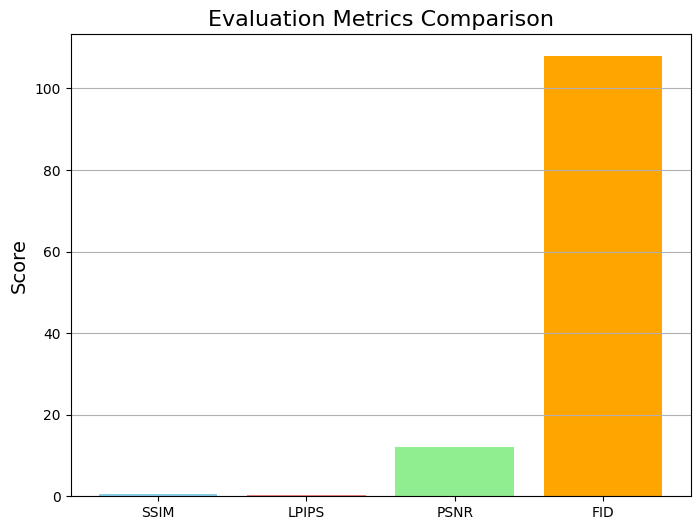

In [20]:

#image 99

import lpips
from torchvision.models import inception_v3
import torch.nn.functional as F
import torchvision.transforms as T
import torch
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import numpy as np

# ---------------------------
# Metric Functions
def compute_ssim(img1, img2):
    img1_np = np.array(img1.convert('L'))
    img2_np = np.array(img2.convert('L'))
    return ssim(img1_np, img2_np)

def compute_lpips(img1, img2, loss_fn):
    preprocess = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize([0.5]*3, [0.5]*3),
    ])
    img1_tensor = preprocess(img1).unsqueeze(0).to('cuda')
    img2_tensor = preprocess(img2).unsqueeze(0).to('cuda')
    with torch.no_grad():
        distance = loss_fn(img1_tensor, img2_tensor)
    return distance.item()

def compute_psnr(img1, img2):
    img1_np = np.array(img1).astype(np.float32)
    img2_np = np.array(img2).astype(np.float32)
    mse = np.mean((img1_np - img2_np) ** 2)
    if mse == 0:
        return float('inf')
    pixel_max = 255.0
    return 20 * np.log10(pixel_max / np.sqrt(mse))

def compute_fid(img1, img2, model):
    preprocess = T.Compose([
        T.Resize((299, 299)),
        T.ToTensor(),
        T.Normalize([0.5]*3, [0.5]*3),
    ])
    img1_tensor = preprocess(img1).unsqueeze(0).to('cuda')
    img2_tensor = preprocess(img2).unsqueeze(0).to('cuda')
    with torch.no_grad():
        act1 = model(img1_tensor).cpu().numpy()
        act2 = model(img2_tensor).cpu().numpy()
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)
    fid = np.sum((mu1 - mu2) ** 2)
    return fid

# ---------------------------
# Load LPIPS and InceptionV3
loss_fn = lpips.LPIPS(net='alex').to('cuda')
inception_model = inception_v3(pretrained=True, transform_input=False).to('cuda')
inception_model.fc = torch.nn.Identity()
inception_model.eval()

# ---------------------------
# Pick frames to compare
frame_base = frames_base[0]
frame_lora = frames_lora[0]

# ---------------------------
# Compute metrics
metrics = {
    'SSIM': compute_ssim(frame_base, frame_lora),
    'LPIPS': compute_lpips(frame_base, frame_lora, loss_fn),
    'PSNR': compute_psnr(frame_base, frame_lora),
    'FID': compute_fid(frame_base, frame_lora, inception_model)
}

# ---------------------------
# Print results
print(f"📊 Evaluation Metrics:\n{metrics}")

# ---------------------------
# Plot the metrics
plt.figure(figsize=(8,6))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'lightcoral', 'lightgreen', 'orange'])
plt.title('Evaluation Metrics Comparison', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.grid(axis='y')
plt.show()


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📊 Evaluation Metrics:
{'SSIM': 0.8432237294832164, 'LPIPS': 0.09294532239437103, 'PSNR': 22.350392683103752, 'FID': 150.0272}


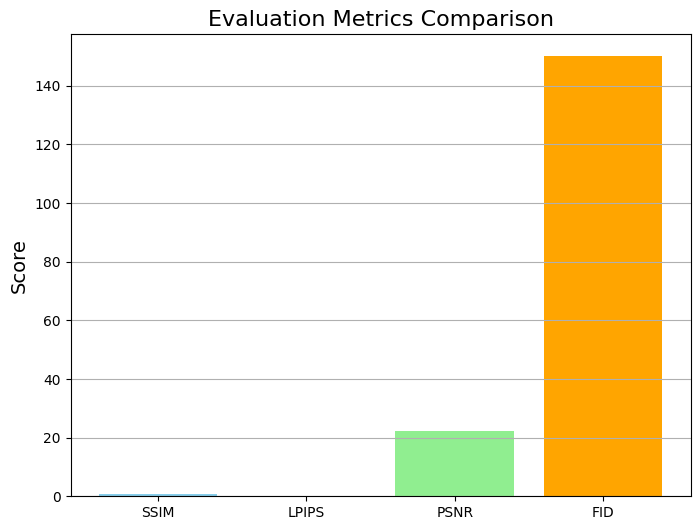

In [5]:

#image 000

import lpips
from torchvision.models import inception_v3
import torch.nn.functional as F
import torchvision.transforms as T
import torch
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import numpy as np

# ---------------------------
# Metric Functions
def compute_ssim(img1, img2):
    img1_np = np.array(img1.convert('L'))
    img2_np = np.array(img2.convert('L'))
    return ssim(img1_np, img2_np)

def compute_lpips(img1, img2, loss_fn):
    preprocess = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize([0.5]*3, [0.5]*3),
    ])
    img1_tensor = preprocess(img1).unsqueeze(0).to('cuda')
    img2_tensor = preprocess(img2).unsqueeze(0).to('cuda')
    with torch.no_grad():
        distance = loss_fn(img1_tensor, img2_tensor)
    return distance.item()

def compute_psnr(img1, img2):
    img1_np = np.array(img1).astype(np.float32)
    img2_np = np.array(img2).astype(np.float32)
    mse = np.mean((img1_np - img2_np) ** 2)
    if mse == 0:
        return float('inf')
    pixel_max = 255.0
    return 20 * np.log10(pixel_max / np.sqrt(mse))

def compute_fid(img1, img2, model):
    preprocess = T.Compose([
        T.Resize((299, 299)),
        T.ToTensor(),
        T.Normalize([0.5]*3, [0.5]*3),
    ])
    img1_tensor = preprocess(img1).unsqueeze(0).to('cuda')
    img2_tensor = preprocess(img2).unsqueeze(0).to('cuda')
    with torch.no_grad():
        act1 = model(img1_tensor).cpu().numpy()
        act2 = model(img2_tensor).cpu().numpy()
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)
    fid = np.sum((mu1 - mu2) ** 2)
    return fid

# ---------------------------
# Load LPIPS and InceptionV3
loss_fn = lpips.LPIPS(net='alex').to('cuda')
inception_model = inception_v3(pretrained=True, transform_input=False).to('cuda')
inception_model.fc = torch.nn.Identity()
inception_model.eval()

# ---------------------------
# Pick frames to compare
frame_base = frames_base[0]
frame_lora = frames_lora[0]

# ---------------------------
# Compute metrics
metrics = {
    'SSIM': compute_ssim(frame_base, frame_lora),
    'LPIPS': compute_lpips(frame_base, frame_lora, loss_fn),
    'PSNR': compute_psnr(frame_base, frame_lora),
    'FID': compute_fid(frame_base, frame_lora, inception_model)
}

# ---------------------------
# Print results
print(f"📊 Evaluation Metrics:\n{metrics}")

# ---------------------------
# Plot the metrics
plt.figure(figsize=(8,6))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'lightcoral', 'lightgreen', 'orange'])
plt.title('Evaluation Metrics Comparison', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.grid(axis='y')
plt.show()


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
📊 Evaluation Metrics:
{'SSIM': 0.5542356720824877, 'LPIPS': 0.17388580739498138, 'PSNR': 12.240181764982909, 'FID': 24.672184}


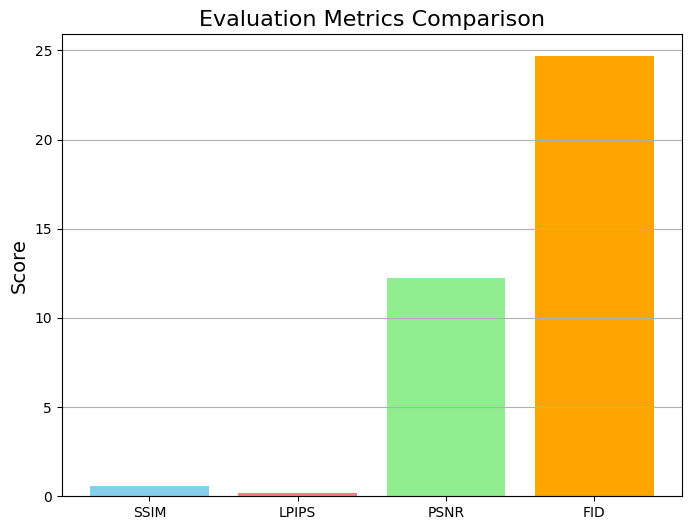

In [21]:

#image 000

import lpips
from torchvision.models import inception_v3
import torch.nn.functional as F
import torchvision.transforms as T
import torch
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import numpy as np

# ---------------------------
# Metric Functions
def compute_ssim(img1, img2):
    img1_np = np.array(img1.convert('L'))
    img2_np = np.array(img2.convert('L'))
    return ssim(img1_np, img2_np)

def compute_lpips(img1, img2, loss_fn):
    preprocess = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize([0.5]*3, [0.5]*3),
    ])
    img1_tensor = preprocess(img1).unsqueeze(0).to('cuda')
    img2_tensor = preprocess(img2).unsqueeze(0).to('cuda')
    with torch.no_grad():
        distance = loss_fn(img1_tensor, img2_tensor)
    return distance.item()

def compute_psnr(img1, img2):
    img1_np = np.array(img1).astype(np.float32)
    img2_np = np.array(img2).astype(np.float32)
    mse = np.mean((img1_np - img2_np) ** 2)
    if mse == 0:
        return float('inf')
    pixel_max = 255.0
    return 20 * np.log10(pixel_max / np.sqrt(mse))

def compute_fid(img1, img2, model):
    preprocess = T.Compose([
        T.Resize((299, 299)),
        T.ToTensor(),
        T.Normalize([0.5]*3, [0.5]*3),
    ])
    img1_tensor = preprocess(img1).unsqueeze(0).to('cuda')
    img2_tensor = preprocess(img2).unsqueeze(0).to('cuda')
    with torch.no_grad():
        act1 = model(img1_tensor).cpu().numpy()
        act2 = model(img2_tensor).cpu().numpy()
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)
    fid = np.sum((mu1 - mu2) ** 2)
    return fid

# ---------------------------
# Load LPIPS and InceptionV3
loss_fn = lpips.LPIPS(net='alex').to('cuda')
inception_model = inception_v3(pretrained=True, transform_input=False).to('cuda')
inception_model.fc = torch.nn.Identity()
inception_model.eval()

# ---------------------------
# Pick frames to compare
frame_base = frames_base[0]
frame_lora = frames_lora[0]

# ---------------------------
# Compute metrics
metrics = {
    'SSIM': compute_ssim(frame_base, frame_lora),
    'LPIPS': compute_lpips(frame_base, frame_lora, loss_fn),
    'PSNR': compute_psnr(frame_base, frame_lora),
    'FID': compute_fid(frame_base, frame_lora, inception_model)
}

# ---------------------------
# Print results
print(f"📊 Evaluation Metrics:\n{metrics}")

# ---------------------------
# Plot the metrics
plt.figure(figsize=(8,6))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'lightcoral', 'lightgreen', 'orange'])
plt.title('Evaluation Metrics Comparison', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.grid(axis='y')
plt.show()
